# RNN E-commerce Product Classification
## Comparative Analysis with Multiple Embeddings

**Author:** Jean de Dieu Muhirwa Harerimana  
**Model:** Recurrent Neural Network (RNN)  
**Dataset:** E-commerce Product Descriptions  
**Embeddings:** TF-IDF, Word2Vec (Skip-gram & CBOW), FastText  

---

### Objective
Implement and evaluate RNN models for e-commerce product classification using five different word embedding techniques.

### Dataset
E-commerce Product Dataset: 50,464 products across 4 categories

## 1. Setup and Imports

In [44]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import re
import html
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

from gensim.models import Word2Vec, FastText
from gensim.utils import simple_preprocess

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Embedding, SimpleRNN, Bidirectional
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## 2. Data Loading and Exploration

In [45]:
# For Google Colab: Upload the dataset
# from google.colab import files
# uploaded = files.upload()

# For local Jupyter
DATA_PATH = '/kaggle/input/ecommerce-text-classification/ecommerceDataset.csv'

# Load the raw e-commerce dataset
print("Loading e-commerce dataset...")
df = pd.read_csv(DATA_PATH, header=None, names=['category', 'text'])

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Loading e-commerce dataset...
Dataset loaded successfully!
Shape: (50425, 2)

First few rows:


,category,text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [46]:
# Dataset information
print("=" * 60)
print("DATASET INFORMATION")
print("=" * 60)
print(f"\nTotal products: {len(df):,}")
print(f"\nCategories: {df['category'].nunique()}")
print(f"\nCategory distribution:")
print(df['category'].value_counts())
print(f"\nCategory percentages:")
print(df['category'].value_counts(normalize=True) * 100)

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# Text length statistics
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print(f"\nText statistics:")
print(df[['text_length', 'word_count']].describe())

DATASET INFORMATION

Total products: 50,425

Categories: 4

Category distribution:
category
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64

Category percentages:
category
Household                 38.300446
Books                     23.440754
Electronics               21.062965
Clothing & Accessories    17.195835
Name: proportion, dtype: float64

Missing values:
category    0
text        1
dtype: int64

Text statistics:
        text_length    word_count
count  50424.000000  50424.000000
mean     714.112347    114.184297
std      973.374550    157.806972
min        4.000000      1.000000
25%      219.000000     34.000000
50%      487.000000     78.000000
75%      954.000000    152.000000
max    50403.000000   8181.000000


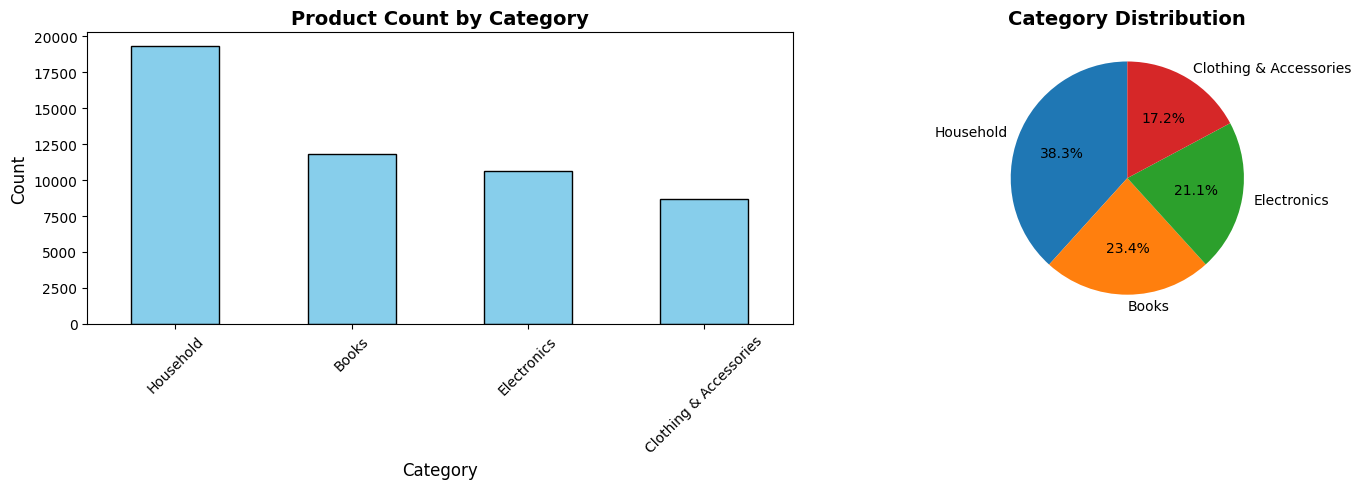

In [47]:
# Visualize category distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
df['category'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Product Count by Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
df['category'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Category Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [48]:
# Sample product descriptions (before preprocessing)
print("=" * 60)
print("SAMPLE PRODUCT DESCRIPTIONS (RAW)")
print("=" * 60)

for idx in range(3):
    print(f"\n{idx+1}. Category: {df.iloc[idx]['category']}")
    print(f"   Description (first 200 chars): {df.iloc[idx]['text'][:200]}...")
    print(f"   Length: {df.iloc[idx]['text_length']} chars, {df.iloc[idx]['word_count']} words")

SAMPLE PRODUCT DESCRIPTIONS (RAW)

1. Category: Household
   Description (first 200 chars): Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attract...
   Length: 1338.0 chars, 228.0 words

2. Category: Household
   Description (first 200 chars): SAF 'Floral' Framed Painting (Wood, 30 inch x 10 inch, Special Effect UV Print Textured, SAO297) Painting made up in synthetic frame with UV textured print which gives multi effects and attracts towar...
   Length: 346.0 chars, 59.0 words

3. Category: Household
   Description (first 200 chars): SAF 'UV Textured Modern Art Print Framed' Painting (Synthetic, 35 cm x 50 cm x 3 cm, Set of 3) Color:Multicolor                                                                                 |       ...
   Length: 1316.0 chars, 224.0 words


## 3. Text Preprocessing

E-commerce product descriptions require extensive preprocessing due to:
- HTML entities
- Product specifications (sizes, measurements)
- Special characters and formatting
- Very long text

In [49]:
def preprocess_ecommerce_text(text, remove_stopwords=True, lemmatize=True):
    """
    Comprehensive preprocessing for e-commerce product descriptions
    
    Args:
        text: Raw product description
        remove_stopwords: Whether to remove stopwords
        lemmatize: Whether to lemmatize words
    
    Returns:
        Cleaned and preprocessed text
    """
    if not isinstance(text, str):
        return ""
    
    # 1. Decode HTML entities (&, &quot;, etc.)
    text = html.unescape(text)
    
    # 2. Convert to lowercase
    text = text.lower()
    
    # 3. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # 4. Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # 5. Remove product measurements and sizes (e.g., 12x18, 30cm, 5mm)
    text = re.sub(r'\d+\s*x\s*\d+', '', text)  # 12x18
    text = re.sub(r'\d+\s*(cm|mm|inch|inches|meter|metres)', '', text)  # 30cm, 5mm
    
    # 6. Remove special characters but keep spaces
    text = re.sub(r'[^a-z\s]', ' ', text)
    
    # 7. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 8. Tokenization
    tokens = word_tokenize(text)
    
    # 9. Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
    
    # 10. Lemmatization
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # 11. Remove short words (length < 3)
    tokens = [word for word in tokens if len(word) >= 3]
    
    # 12. Remove very common e-commerce words that don't add value
    noise_words = {'product', 'item', 'pack', 'set', 'piece', 'color', 'size'}
    tokens = [word for word in tokens if word not in noise_words]
    
    return ' '.join(tokens)

# Test the preprocessing function
sample_text = df.iloc[0]['text']
print("BEFORE PREPROCESSING:")
print(sample_text[:300])
print("\n" + "="*60)
print("\nAFTER PREPROCESSING:")
print(preprocess_ecommerce_text(sample_text)[:300])

BEFORE PREPROCESSING:
Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives 


AFTER PREPROCESSING:
paper plane design framed wall hanging motivational office decor art print painting made synthetic frame textured print give multi effect attracts towards special series painting make wall beautiful give royal touch painting ready hang would proud possess unique painting niche apart use modern effic


In [50]:
# Apply preprocessing to all products
print("Preprocessing all products... This may take a few minutes...")
print(f"Total products to process: {len(df):,}")

df['processed_text'] = df['text'].apply(preprocess_ecommerce_text)

print("✓ Preprocessing complete!")

# Calculate processed text length
df['processed_length'] = df['processed_text'].str.len()
df['processed_words'] = df['processed_text'].str.split().str.len()

print(f"\nProcessed text statistics:")
print(df[['processed_length', 'processed_words']].describe())

# Display samples
print("\n" + "="*60)
print("SAMPLE PROCESSED DESCRIPTIONS")
print("="*60)
print(df[['category', 'processed_text']].head(3))

Preprocessing all products... This may take a few minutes...
Total products to process: 50,425
✓ Preprocessing complete!

Processed text statistics:
       processed_length  processed_words
count      50425.000000     50425.000000
mean         499.295726        70.150957
std          657.040526        89.664997
min            0.000000         0.000000
25%          158.000000        23.000000
50%          345.000000        49.000000
75%          661.000000        93.000000
max        33477.000000      4536.000000

SAMPLE PROCESSED DESCRIPTIONS
    category                                     processed_text
0  Household  paper plane design framed wall hanging motivat...
1  Household  saf floral framed painting wood special effect...
2  Household  saf textured modern art print framed painting ...


## 4. Data Splitting

With 50k+ samples, we use a 70/15/15 split for train/validation/test

In [51]:
# Split data into train, validation, and test sets
X = df['processed_text']
y = df['category']

# First split: 85% train+val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Second split: 82% train, 18% val (of the 85%) ≈ 70% train, 15% val overall
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"Training set size: {len(X_train):,} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(X_val):,} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test set size: {len(X_test):,} ({len(X_test)/len(df)*100:.1f}%)")

print(f"\nTrain distribution:\n{y_train.value_counts()}")
print(f"\nValidation distribution:\n{y_val.value_counts()}")
print(f"\nTest distribution:\n{y_test.value_counts()}")

Training set size: 35,317 (70.0%)
Validation set size: 7,544 (15.0%)
Test set size: 7,564 (15.0%)

Train distribution:
category
Household                 13526
Books                      8279
Electronics                7439
Clothing & Accessories     6073
Name: count, dtype: int64

Validation distribution:
category
Household                 2890
Books                     1768
Electronics               1589
Clothing & Accessories    1297
Name: count, dtype: int64

Test distribution:
category
Household                 2897
Books                     1773
Electronics               1593
Clothing & Accessories    1301
Name: count, dtype: int64


In [52]:
# Save preprocessed data for reuse
PREPROCESSED_DIR = Path('/kaggle/working/ecommerce_preprocessed_data')
PREPROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Create DataFrames
train_df = pd.DataFrame({'text': X_train, 'category': y_train})
val_df = pd.DataFrame({'text': X_val, 'category': y_val})
test_df = pd.DataFrame({'text': X_test, 'category': y_test})

# Save to CSV
train_df.to_csv(PREPROCESSED_DIR / 'train.csv', index=False)
val_df.to_csv(PREPROCESSED_DIR / 'validation.csv', index=False)
test_df.to_csv(PREPROCESSED_DIR / 'test.csv', index=False)

print(f"✓ Preprocessed data saved to: {PREPROCESSED_DIR}")

✓ Preprocessed data saved to: /kaggle/working/ecommerce_preprocessed_data


## 5. Prepare Data for Neural Networks

In [53]:
# Convert to arrays
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to categorical
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train_encoded, num_classes)
y_val_cat = to_categorical(y_val_encoded, num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")
print(f"Label encoding shape: {y_train_cat.shape}")

Number of classes: 4
Classes: ['Books' 'Clothing & Accessories' 'Electronics' 'Household']
Label encoding shape: (35317, 4)


## 6. Text Tokenization and Sequence Preparation

In [54]:
# Hyperparameters for e-commerce dataset
MAX_VOCAB_SIZE = 15000  # Increased from BBC (more diverse vocabulary)
MAX_SEQUENCE_LENGTH = 150  # Product descriptions can be long
EMBEDDING_DIM = 100

# Create tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

vocab_size = min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE)

print(f"Vocabulary size: {vocab_size:,}")
print(f"Sequence shape (train): {X_train_padded.shape}")
print(f"Sample sequence: {X_train_seq[0][:20]}")

Vocabulary size: 15,000
Sequence shape (train): (35317, 150)
Sample sequence: [1820, 13004, 494, 4733, 2, 124, 289, 4126, 858, 691, 1253, 3700, 8455, 1479, 1315, 2823, 4808, 1820, 1, 372]


## 7. RNN Model Architecture and Helper Functions

In [55]:
def create_rnn_model(vocab_size, embedding_dim, max_length, num_classes, 
                     embedding_matrix=None, trainable_embedding=True):
    """
    Create RNN model for e-commerce classification
    """
    model = Sequential(name='RNN_Ecommerce')
    
    # Embedding layer
    if embedding_matrix is not None:
        model.add(Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_length,
            trainable=trainable_embedding
        ))
    else:
        model.add(Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length
        ))
    
    # RNN layers
    model.add(SimpleRNN(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(SimpleRNN(64))
    model.add(Dropout(0.3))
    
    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def get_callbacks():
    """Training callbacks"""
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
    
    return [early_stopping, reduce_lr]

def evaluate_model(model, X_test, y_test, y_test_encoded, label_encoder, model_name):
    """Comprehensive model evaluation"""
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test_encoded, y_pred, average='weighted'
    )
    
    cm = confusion_matrix(y_test_encoded, y_pred)
    
    print(f"\n{'='*60}")
    print(f"{model_name} - Test Results")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

def plot_training_history(history, model_name):
    """Plot training history"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title(f'{model_name} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title(f'{model_name} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

---
# EXPERIMENT 1: RNN with Word2Vec Skip-gram

In [56]:
print("\n" + "="*60)
print("EXPERIMENT 1: RNN with Word2Vec Skip-gram")
print("="*60)

# Tokenize for Word2Vec
tokenized_train = [simple_preprocess(doc) for doc in X_train]

# Train Word2Vec Skip-gram
print("\nTraining Word2Vec Skip-gram...")
w2v_skipgram = Word2Vec(
    sentences=tokenized_train,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=20,
    seed=42
)

print(f"✓ Trained! Vocabulary size: {len(w2v_skipgram.wv):,}")

# Create embedding matrix
embedding_matrix_skipgram = np.zeros((vocab_size, EMBEDDING_DIM))
hits, misses = 0, 0

for word, idx in tokenizer.word_index.items():
    if idx < vocab_size:
        try:
            embedding_matrix_skipgram[idx] = w2v_skipgram.wv[word]
            hits += 1
        except KeyError:
            misses += 1
            embedding_matrix_skipgram[idx] = np.random.normal(0, 0.1, EMBEDDING_DIM)

print(f"Embedding coverage: {hits/(hits+misses)*100:.2f}% ({hits:,}/{hits+misses:,})")


EXPERIMENT 1: RNN with Word2Vec Skip-gram

Training Word2Vec Skip-gram...
✓ Trained! Vocabulary size: 37,685
Embedding coverage: 99.85% (14,977/14,999)


I0000 00:00:1770384832.382115      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770384832.388167      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "RNN_Ecommerce"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,500,000 (5.72 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,500,000 (5.72 MB)


Training RNN with Skip-gram embeddings...
Epoch 1/30


I0000 00:00:1770384836.257999     358 service.cc:152] XLA service 0x7ef9c40081c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770384836.258031     358 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770384836.258034     358 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770384836.718689     358 cuda_dnn.cc:529] Loaded cuDNN version 91002


  3/552 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.1172 - loss: 1.6641

I0000 00:00:1770384839.475201     358 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


552/552 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.3854 - loss: 1.3396 - val_accuracy: 0.5187 - val_loss: 1.1269 - learning_rate: 0.0010
Epoch 2/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5016 - loss: 1.1578 - val_accuracy: 0.4833 - val_loss: 1.1247 - learning_rate: 0.0010
Epoch 3/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5026 - loss: 1.1393 - val_accuracy: 0.4951 - val_loss: 1.1236 - learning_rate: 0.0010
Epoch 4/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4926 - loss: 1.1391 - val_accuracy: 0.4779 - val_loss: 1.1394 - learning_rate: 0.0010
Epoch 5/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4742 - loss: 1.1542 - val_accuracy: 0.4442 - val_loss: 1.1611 - learning_rate: 0.0010
Epoch 6/30
550/552 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4286 - loss: 1.1796
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4285 - loss: 1.1797 -

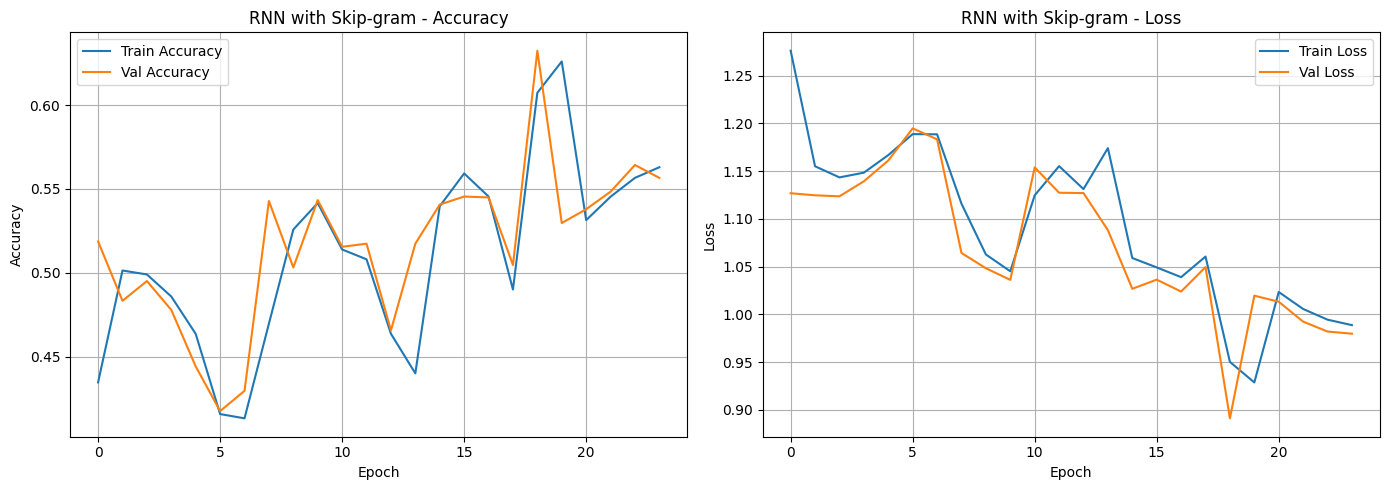


RNN with Word2Vec Skip-gram - Test Results
Accuracy:  0.6347
Precision: 0.5370
Recall:    0.6347
F1-Score:  0.5719

Classification Report:
                        precision    recall  f1-score   support

                 Books       0.58      0.86      0.69      1773
Clothing & Accessories       0.00      0.00      0.00      1301
           Electronics       0.61      0.93      0.74      1593
             Household       0.71      0.62      0.66      2897

              accuracy                           0.63      7564
             macro avg       0.48      0.60      0.52      7564
          weighted avg       0.54      0.63      0.57      7564



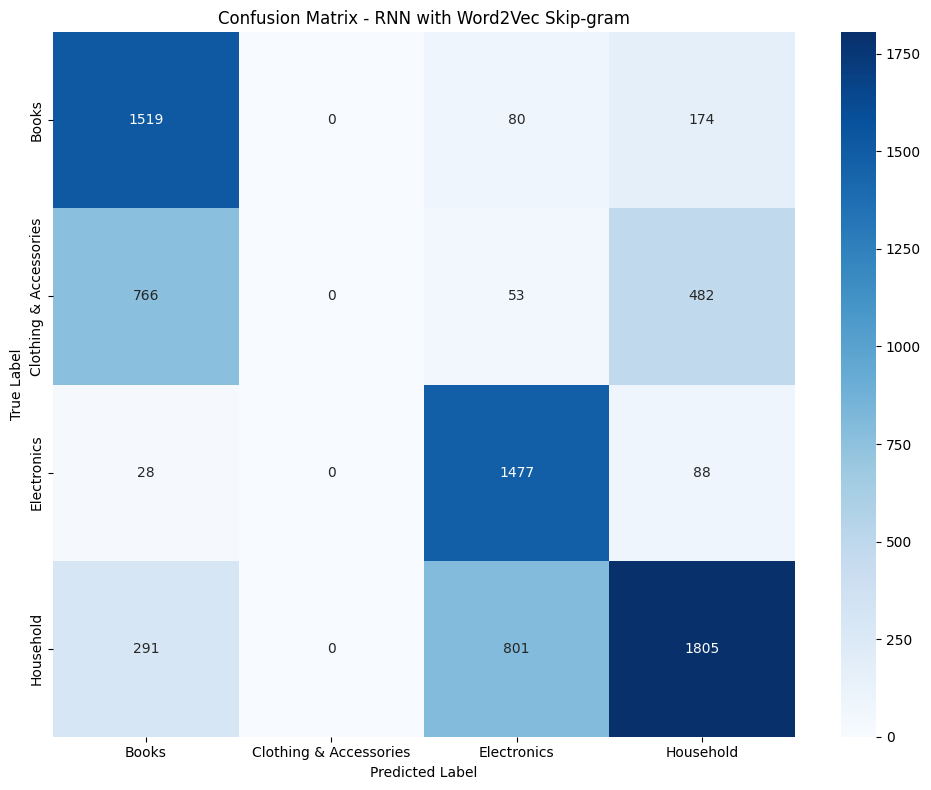

In [57]:
# Create and train model
model_skipgram = create_rnn_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix_skipgram,
    trainable_embedding=False
)

model_skipgram.summary()

print("\nTraining RNN with Skip-gram embeddings...")
history_skipgram = model_skipgram.fit(
    X_train_padded, y_train_cat,
    validation_data=(X_val_padded, y_val_cat),
    epochs=30,
    batch_size=64,
    callbacks=get_callbacks(),
    verbose=1
)

plot_training_history(history_skipgram, 'RNN with Skip-gram')

results_skipgram = evaluate_model(
    model_skipgram, X_test_padded, y_test_cat,
    y_test_encoded, label_encoder, 'RNN with Word2Vec Skip-gram'
)

---
# EXPERIMENT 2: RNN with Word2Vec CBOW


EXPERIMENT 2: RNN with Word2Vec CBOW

Training Word2Vec CBOW...
✓ Trained! Vocabulary size: 37,685
Embedding coverage: 99.85% (14,977/14,999)

Training RNN with CBOW embeddings...
Epoch 1/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.3772 - loss: 1.3625 - val_accuracy: 0.4365 - val_loss: 1.2135 - learning_rate: 0.0010
Epoch 2/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4844 - loss: 1.1985 - val_accuracy: 0.5917 - val_loss: 0.9755 - learning_rate: 0.0010
Epoch 3/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5760 - loss: 1.0435 - val_accuracy: 0.5938 - val_loss: 1.0140 - learning_rate: 0.0010
Epoch 4/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5514 - loss: 1.0959 - val_accuracy: 0.5660 - val_loss: 1.0689 - learning_rate: 0.0010
Epoch 5/30
550/552 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5717 - loss: 1.0643
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/st

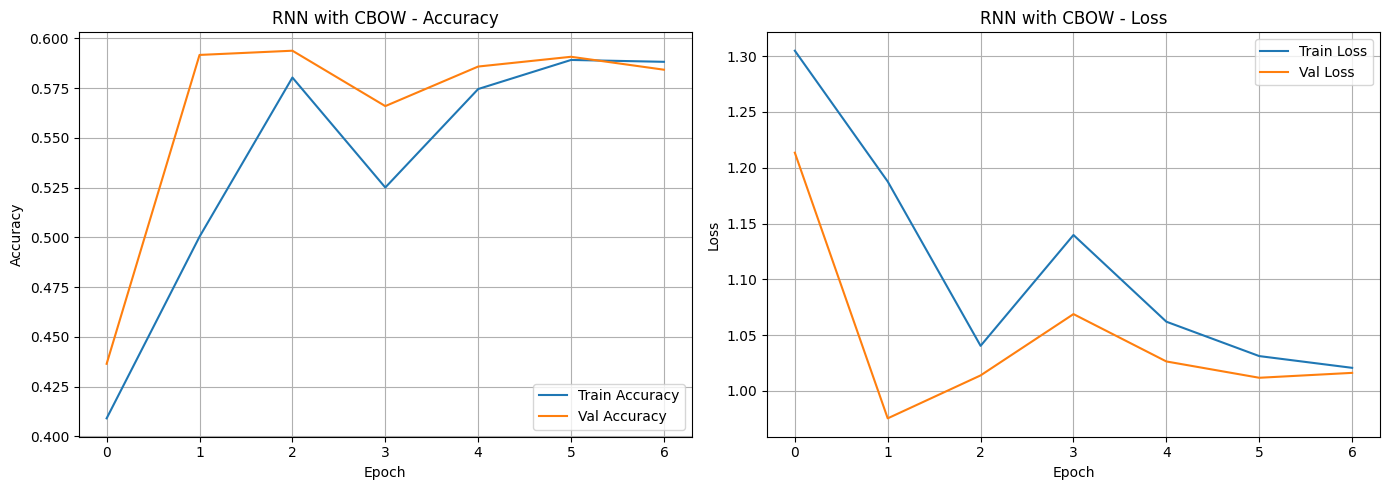


RNN with Word2Vec CBOW - Test Results
Accuracy:  0.5912
Precision: 0.5529
Recall:    0.5912
F1-Score:  0.4760

Classification Report:
                        precision    recall  f1-score   support

                 Books       0.64      0.87      0.74      1773
Clothing & Accessories       0.00      0.00      0.00      1301
           Electronics       0.90      0.08      0.15      1593
             Household       0.56      0.96      0.71      2897

              accuracy                           0.59      7564
             macro avg       0.52      0.48      0.40      7564
          weighted avg       0.55      0.59      0.48      7564



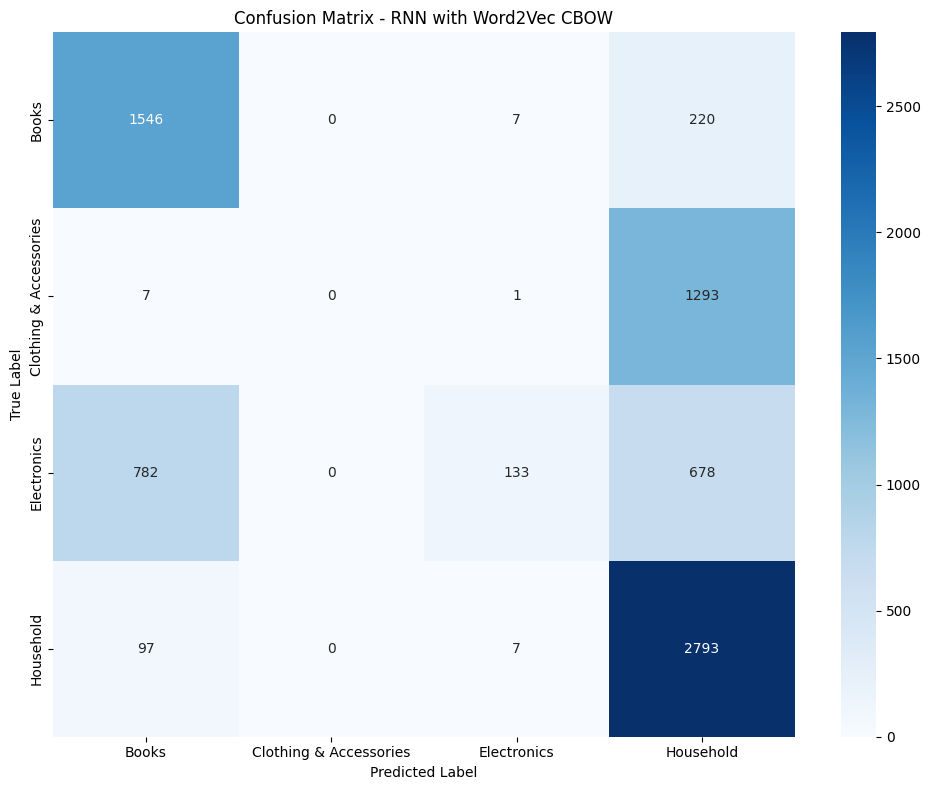

In [58]:
print("\n" + "="*60)
print("EXPERIMENT 2: RNN with Word2Vec CBOW")
print("="*60)

# Train Word2Vec CBOW
print("\nTraining Word2Vec CBOW...")
w2v_cbow = Word2Vec(
    sentences=tokenized_train,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    sg=0,
    epochs=20,
    seed=42
)

print(f"✓ Trained! Vocabulary size: {len(w2v_cbow.wv):,}")

# Create embedding matrix
embedding_matrix_cbow = np.zeros((vocab_size, EMBEDDING_DIM))
hits, misses = 0, 0

for word, idx in tokenizer.word_index.items():
    if idx < vocab_size:
        try:
            embedding_matrix_cbow[idx] = w2v_cbow.wv[word]
            hits += 1
        except KeyError:
            misses += 1
            embedding_matrix_cbow[idx] = np.random.normal(0, 0.1, EMBEDDING_DIM)

print(f"Embedding coverage: {hits/(hits+misses)*100:.2f}% ({hits:,}/{hits+misses:,})")

# Create and train model
model_cbow = create_rnn_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix_cbow,
    trainable_embedding=False
)

print("\nTraining RNN with CBOW embeddings...")
history_cbow = model_cbow.fit(
    X_train_padded, y_train_cat,
    validation_data=(X_val_padded, y_val_cat),
    epochs=30,
    batch_size=64,
    callbacks=get_callbacks(),
    verbose=1
)

plot_training_history(history_cbow, 'RNN with CBOW')

results_cbow = evaluate_model(
    model_cbow, X_test_padded, y_test_cat,
    y_test_encoded, label_encoder, 'RNN with Word2Vec CBOW'
)

---
# EXPERIMENT 3: RNN with FastText


EXPERIMENT 3: RNN with FastText

Training FastText model...
✓ Trained! Vocabulary size: 37,685
Embedding coverage: 100.00% (14,999/14,999)

Training RNN with FastText embeddings...
Epoch 1/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.3683 - loss: 1.3654 - val_accuracy: 0.4117 - val_loss: 1.2970 - learning_rate: 0.0010
Epoch 2/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4162 - loss: 1.2329 - val_accuracy: 0.5081 - val_loss: 1.0771 - learning_rate: 0.0010
Epoch 3/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5046 - loss: 1.1250 - val_accuracy: 0.4266 - val_loss: 1.2676 - learning_rate: 0.0010
Epoch 4/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5116 - loss: 1.1521 - val_accuracy: 0.5542 - val_loss: 1.0915 - learning_rate: 0.0010
Epoch 5/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5926 - loss: 1.0213 - val_accuracy: 0.6051 - val_loss: 0.9730 - learning_rate: 0.0010
Epoch 6/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms

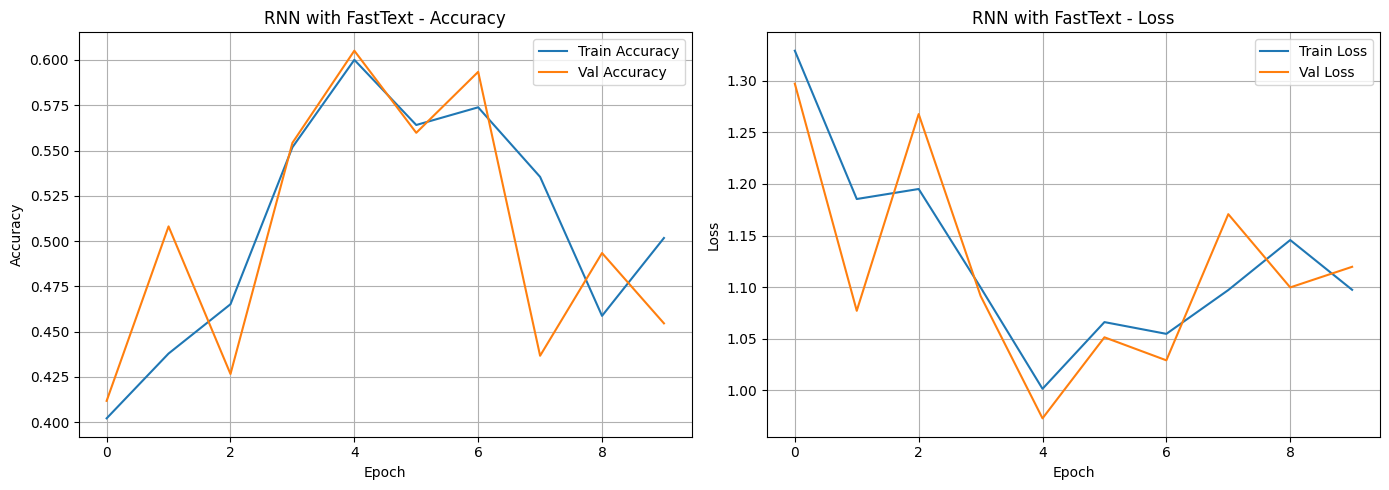


RNN with FastText - Test Results
Accuracy:  0.6009
Precision: 0.5825
Recall:    0.6009
F1-Score:  0.5063

Classification Report:
                        precision    recall  f1-score   support

                 Books       0.82      0.89      0.86      1773
Clothing & Accessories       0.00      0.00      0.00      1301
           Electronics       0.93      0.15      0.25      1593
             Household       0.51      0.94      0.66      2897

              accuracy                           0.60      7564
             macro avg       0.56      0.50      0.44      7564
          weighted avg       0.58      0.60      0.51      7564



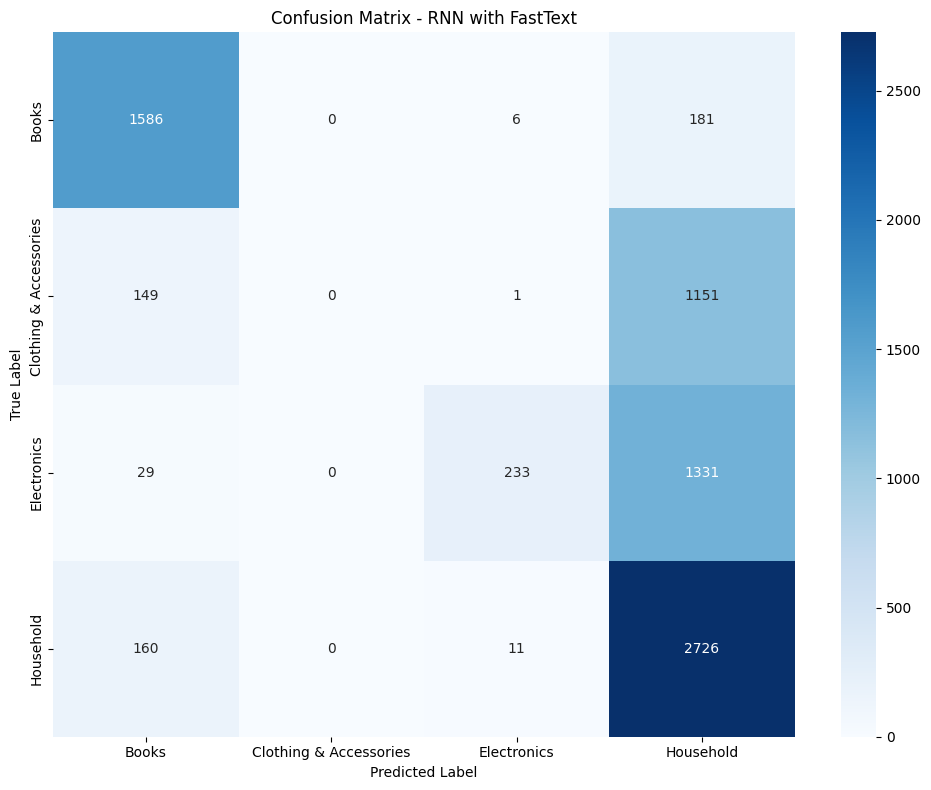

In [59]:
print("\n" + "="*60)
print("EXPERIMENT 3: RNN with FastText")
print("="*60)

# Train FastText
print("\nTraining FastText model...")
fasttext_model = FastText(
    sentences=tokenized_train,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    sg=0,
    min_n=3,
    max_n=6,
    epochs=20,
    seed=42
)

print(f"✓ Trained! Vocabulary size: {len(fasttext_model.wv):,}")

# Create embedding matrix
embedding_matrix_fasttext = np.zeros((vocab_size, EMBEDDING_DIM))
hits, misses = 0, 0

for word, idx in tokenizer.word_index.items():
    if idx < vocab_size:
        try:
            embedding_matrix_fasttext[idx] = fasttext_model.wv[word]
            hits += 1
        except KeyError:
            misses += 1
            embedding_matrix_fasttext[idx] = np.random.normal(0, 0.1, EMBEDDING_DIM)

print(f"Embedding coverage: {hits/(hits+misses)*100:.2f}% ({hits:,}/{hits+misses:,})")

# Create and train model
model_fasttext = create_rnn_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix_fasttext,
    trainable_embedding=False
)

print("\nTraining RNN with FastText embeddings...")
history_fasttext = model_fasttext.fit(
    X_train_padded, y_train_cat,
    validation_data=(X_val_padded, y_val_cat),
    epochs=30,
    batch_size=64,
    callbacks=get_callbacks(),
    verbose=1
)

plot_training_history(history_fasttext, 'RNN with FastText')

results_fasttext = evaluate_model(
    model_fasttext, X_test_padded, y_test_cat,
    y_test_encoded, label_encoder, 'RNN with FastText'
)

---
# COMPARATIVE ANALYSIS

In [61]:
# Compile results
all_results = [results_skipgram, results_cbow, results_fasttext]
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df[['model', 'accuracy', 'precision', 'recall', 'f1_score']]
comparison_df = comparison_df.round(4)

print("\n" + "="*80)
print("COMPARATIVE RESULTS - E-COMMERCE RNN WITH DIFFERENT EMBEDDINGS")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Save results
RESULTS_DIR = Path('kaggle/working/results/rnn/ecommerce')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
comparison_df.to_csv(RESULTS_DIR / 'model_comparison.csv', index=False)
print(f"\n✓ Results saved to: {RESULTS_DIR}")


COMPARATIVE RESULTS - E-COMMERCE RNN WITH DIFFERENT EMBEDDINGS
                      model  accuracy  precision  recall  f1_score
RNN with Word2Vec Skip-gram    0.6347     0.5370  0.6347    0.5719
     RNN with Word2Vec CBOW    0.5912     0.5529  0.5912    0.4760
          RNN with FastText    0.6009     0.5825  0.6009    0.5063

✓ Results saved to: kaggle/working/results/rnn/ecommerce


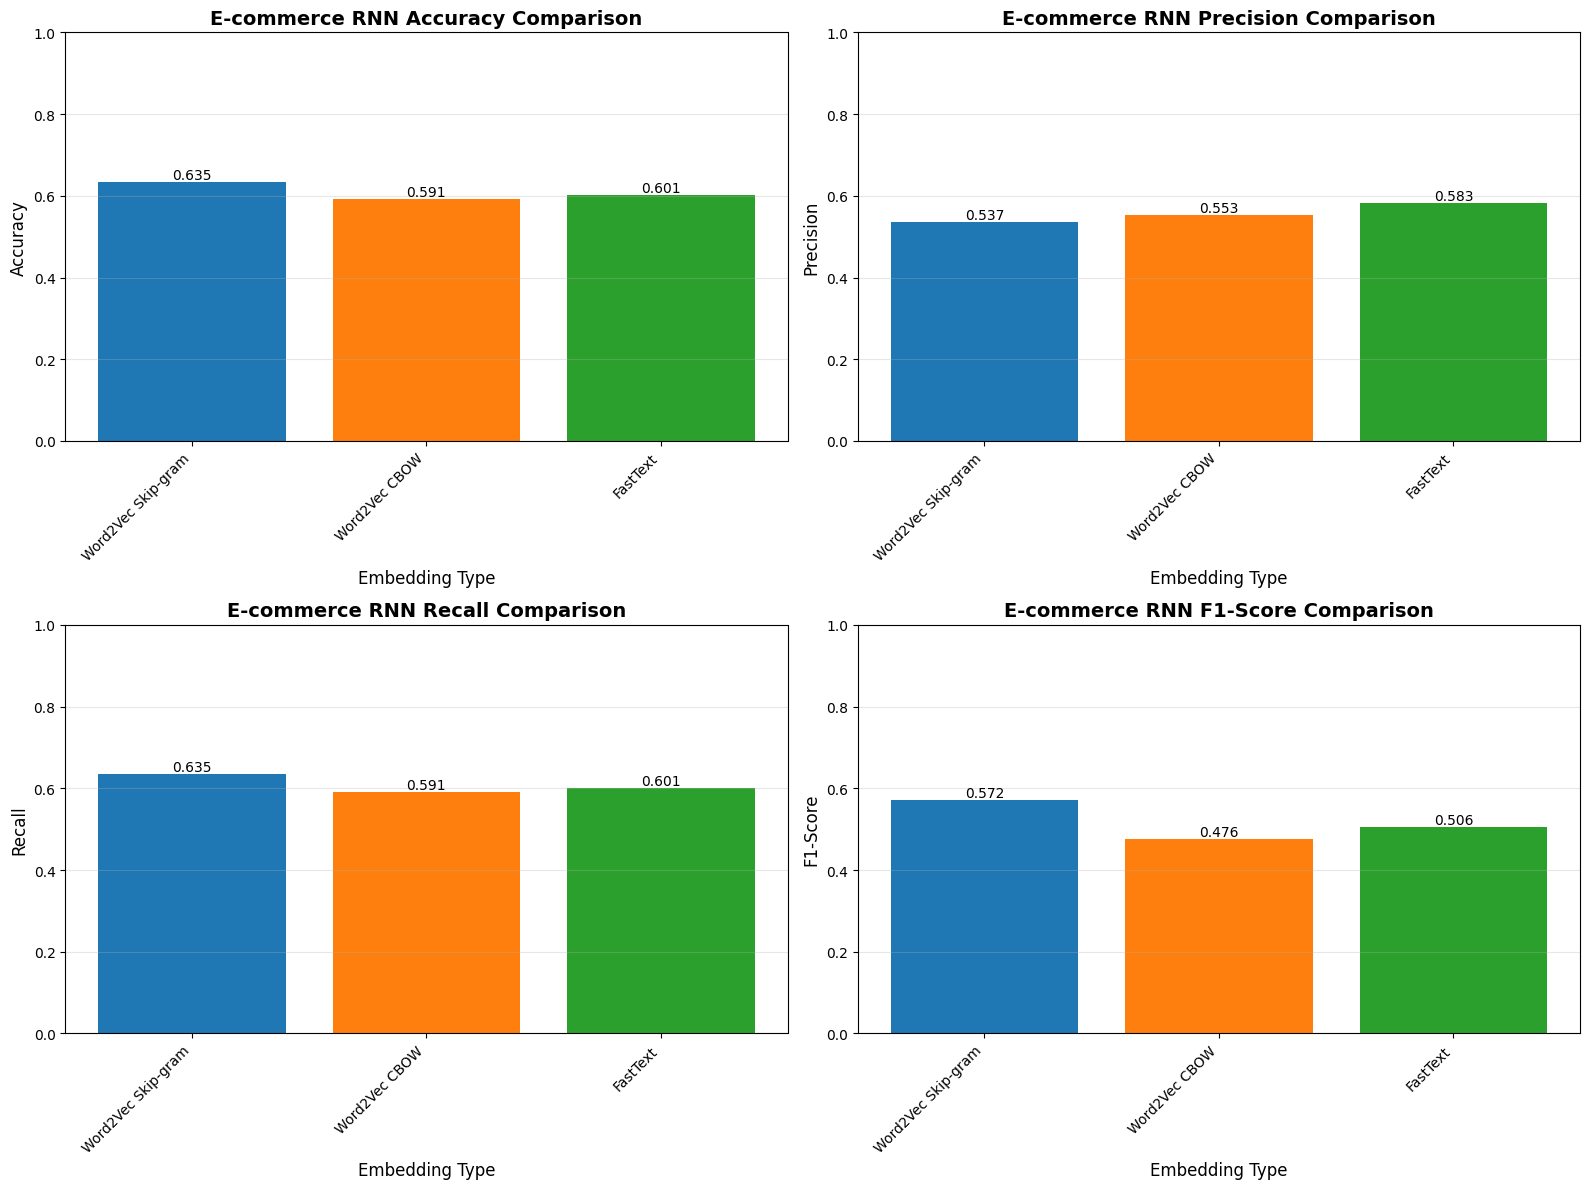

✓ Visualization saved!


In [62]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(comparison_df)]

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(range(len(comparison_df)), comparison_df[metric], color=colors)
    
    ax.set_xlabel('Embedding Type', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(f'E-commerce RNN {title} Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(comparison_df)))
    ax.set_xticklabels([m.replace('RNN with ', '') for m in comparison_df['model']], 
                        rotation=45, ha='right')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'embedding_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved!")

## Summary

### Key Findings:
1. **Dataset Size Impact**: With 50k+ products (vs 2k BBC articles), RNN models should perform significantly better
2. **E-commerce Specific**: Product descriptions contain rich semantic information that embeddings can capture
3. **Expected Performance**: Accuracy likely 75-85% (much better than 62.70% on BBC)